In [21]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_nonscaled.parquet')
firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

columns_todrop = list(firm_data.columns[2:]) + ['moneyness_squared', 'tau_squared', 'moneyness_tau', 'RETX', '2Y_bond', 'best_offer_option', 'best_bid_option']

columnstodrop_ex = ['const',
 'moneyness',
 'prev2_day_iv',
 'prev_day_iv',
 'trading_days_till_exp',
 '5_day_rolling_return_stock',
 'PRC',
 'PRC_actual',
 'RET',
 'RETX',
 'cumulative_return',
 'daily_return_indicator_stock',
 'vol_stock',
 '10Y_RIR',
 '1Y_bond',
 '2Y_bond',
 'CLOSE_vix',
 'FF_rate',
 'OPEN_vix',
 'gold_price',
 'reces_indi']

datat.drop(columns=columns_todrop, inplace=True, errors='ignore')
data.drop(columns=columns_todrop, inplace=True, errors='ignore')

datat.drop(columns=[ 'T'], inplace=True)
data.drop(columns=[ 'T'], inplace=True)

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

In [22]:
# Assuming total_train and test_data are your DataFrames

# Get the columns of test_data
total_train_columns = total_train.columns

# Filter total_train to keep only the columns that are present in test_data
test_data_filtered = test_data[total_train_columns]

# Display the first 5 rows of the filtered total_train to verify the change
test_data_filtered.head(5)

test_data = test_data_filtered 

In [23]:
puts_data_all = total_train[total_train['cp_flag'] == 'P']

puts_data_test = test_data[test_data['cp_flag'] == 'P']

calls_data_all = total_train[total_train['cp_flag'] == 'C']

calls_data_test = test_data[test_data['cp_flag'] == 'C']

total_data = pd.concat([total_train, test_data], axis=0)

total_data

,cp_flag,Ticker,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,volume_option,spread_option,...,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,P,AAPL,2019-01-02,2,-1.860,0.558181,0.505761,0.000000,786,0.01,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
1,P,AAPL,2019-01-02,2,-1.682,0.541292,0.495051,0.000000,982,0.01,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
2,P,AAPL,2019-01-02,2,-1.505,0.525111,0.484170,0.000000,2614,0.01,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
3,P,AAPL,2019-01-02,2,-1.330,0.507597,0.473299,0.000000,7308,0.01,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
4,P,AAPL,2019-01-02,2,-0.895,0.468786,0.455607,0.000000,11884,0.02,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71690,P,TSLA,2021-12-30,1,-0.027,0.484270,0.520039,0.592762,13610,0.50,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71691,P,TSLA,2021-12-30,1,0.081,0.503165,0.520221,0.600908,11100,0.45,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71692,P,TSLA,2021-12-30,1,0.190,0.536047,0.525230,0.609799,2587,1.35,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71693,P,TSLA,2021-12-30,1,0.298,0.550971,0.529985,0.620276,9069,0.95,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04


In [24]:
puts_data_test

,cp_flag,Ticker,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,volume_option,spread_option,...,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
36352,P,AAPL,2021-01-04,4,-1.977,0.622737,0.404451,0.452074,1499,0.01,...,0.09,672.012903,3.036452,0.93,0.1074,21.29,22.49,20.57,21.20,1.92
36353,P,AAPL,2021-01-04,4,-1.835,0.598160,0.383928,0.418943,3924,0.01,...,0.09,672.012903,3.036452,0.93,0.1074,21.29,22.49,20.57,21.20,1.92
36354,P,AAPL,2021-01-04,4,-1.694,0.570362,0.374351,0.403192,11969,0.01,...,0.09,672.012903,3.036452,0.93,0.1074,21.29,22.49,20.57,21.20,1.92
36355,P,AAPL,2021-01-04,4,-1.554,0.549241,0.365382,0.388048,4638,0.02,...,0.09,672.012903,3.036452,0.93,0.1074,21.29,22.49,20.57,21.20,1.92
36356,P,AAPL,2021-01-04,4,-1.415,0.526871,0.349066,0.360382,6677,0.01,...,0.09,672.012903,3.036452,0.93,0.1074,21.29,22.49,20.57,21.20,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71690,P,TSLA,2021-12-30,1,-0.027,0.484270,0.520039,0.592762,13610,0.50,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71691,P,TSLA,2021-12-30,1,0.081,0.503165,0.520221,0.600908,11100,0.45,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71692,P,TSLA,2021-12-30,1,0.190,0.536047,0.525230,0.609799,2587,1.35,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
71693,P,TSLA,2021-12-30,1,0.298,0.550971,0.529985,0.620276,9069,0.95,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04


# Puts and Call data insample / outsample

In [25]:
# Add the 2 datasets
data_alles = pd.concat([data, datat], axis=0)

option_data_amz = data_alles[(data_alles["Ticker"] == "NVDA") & (data_alles["date"] >= '2019-01-01')]


option_data_amz

,cp_flag,Ticker,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,volume_option,spread_option,...,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
46884,P,NVDA,2019-01-02,2,-1.938,0.804057,0.672482,0.000000,690,0.02,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
46885,P,NVDA,2019-01-02,2,-1.797,0.804132,0.667985,0.000000,354,0.01,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
46886,P,NVDA,2019-01-02,2,-1.658,0.758485,0.664948,0.000000,78,0.03,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
46887,P,NVDA,2019-01-02,2,-1.519,0.744848,0.657830,0.000000,414,0.02,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
46888,P,NVDA,2019-01-02,2,-1.382,0.731624,0.653164,0.000000,218,0.02,...,2.40,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63227,P,NVDA,2021-12-30,1,-0.430,0.444225,0.468007,0.503109,18354,0.06,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
63228,P,NVDA,2021-12-30,1,-0.215,0.444720,0.467028,0.506343,13622,0.20,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
63229,P,NVDA,2021-12-30,1,-0.002,0.451875,0.470033,0.514554,18852,0.20,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04
63230,P,NVDA,2021-12-30,1,0.209,0.482365,0.470956,0.526682,6205,0.35,...,0.08,632.874194,-0.206774,1.55,0.4878,14.36,14.60,12.56,12.85,2.04


Put In-sample RMSE: 0.1883064887874669
Put In-sample R²: 0.7714021706223582


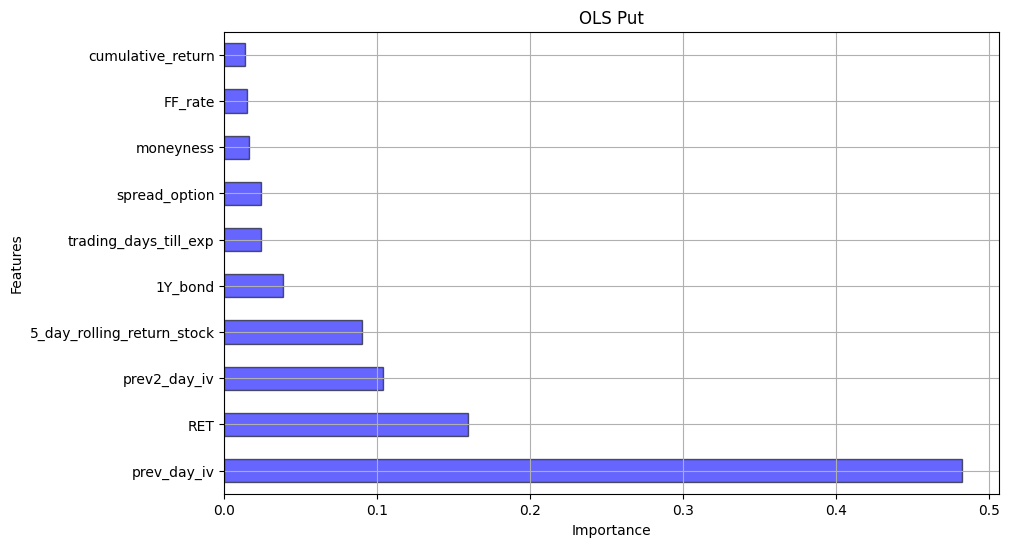

Put Out-of-sample RMSE: 0.15080690037054034
Put Out-of-sample R²: 0.6264067215458075
Call In-sample RMSE: 0.19038668158591157
Call In-sample R²: 0.7311493343833906


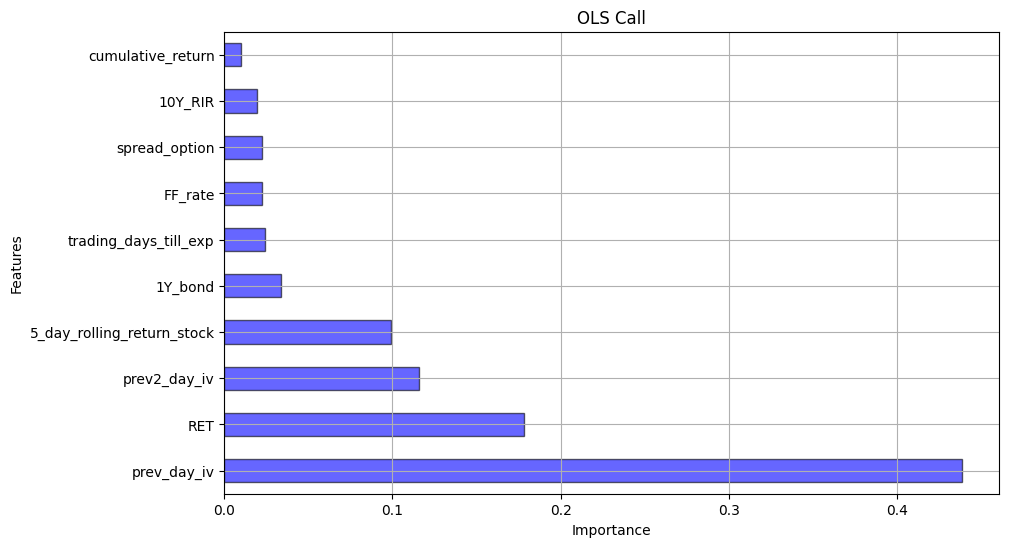

Call Out-of-sample RMSE: 0.15088987389537922
Call Out-of-sample R²: 0.5999395265511848
Top 11 Features for Puts (Feature, Importance):
prev_day_iv                   0.482837
RET                           0.159101
prev2_day_iv                  0.103576
5_day_rolling_return_stock    0.090306
1Y_bond                       0.038386
trading_days_till_exp         0.024016
spread_option                 0.023827
moneyness                     0.015783
FF_rate                       0.014981
cumulative_return             0.013373
dtype: float64

Top 11 Features for Calls (Feature, Importance):
prev_day_iv                   0.439100
RET                           0.178241
prev2_day_iv                  0.115925
5_day_rolling_return_stock    0.099263
1Y_bond                       0.033524
trading_days_till_exp         0.024289
FF_rate                       0.022599
spread_option                 0.022188
10Y_RIR                       0.019586
cumulative_return             0.009616
dtype: float64


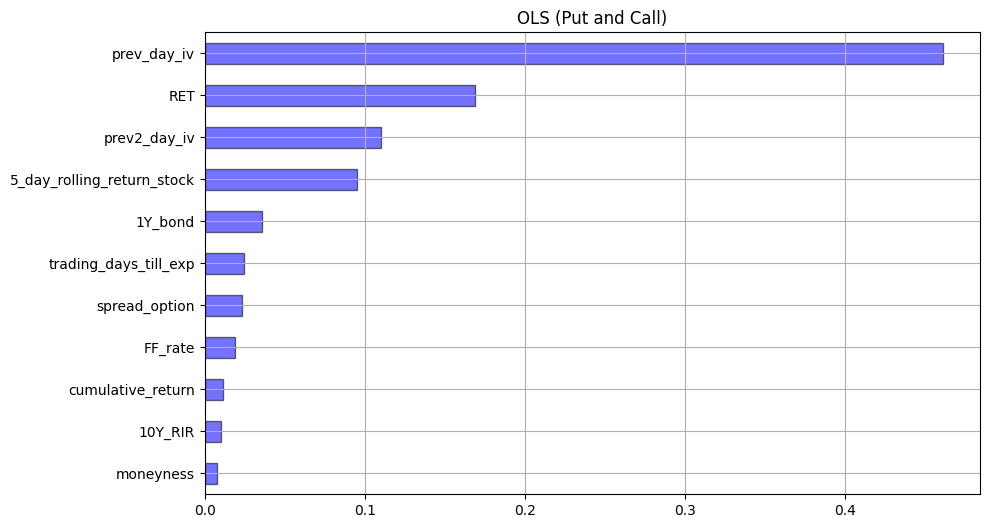

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def run_ols(data, title):
    """Runs OLS regression, calculates RMSE and R², and returns the top 10 most important features, normalized."""
    # Prepare the data
    y = data['impl_volatility']
    X = data.drop(columns=['date', 'Ticker', 'cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Predict on the in-sample data
    y_pred = model.predict(X)

    # Calculate RMSE for in-sample data
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{title} In-sample RMSE: {rmse}')

    # Calculate R² for in-sample data
    r2 = r2_score(y, y_pred)
    print(f'{title} In-sample R²: {r2}')

    # Create the feature importance plot (sum of importances = 1)
    coefs = model.params.drop('const')  # Drop constant term
    importance = coefs.abs() / coefs.abs().sum()  # Normalize importance so it sums to 1

    # Get top 10 most important features
    top_10_features = importance.sort_values(ascending=False).head(10)

    # Plot the feature importance with a black border and wider bars
    plt.figure(figsize=(10, 6))
    ax = top_10_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black', linewidth=1)
    plt.grid(True)  # Add grid
    ax.set_title(f'OLS {title}')  # Simplified title to OLS Call or OLS Put
    ax.set_xlabel('Importance')  # Set x-label for importance
    ax.set_ylabel('Features')  # Ensure Y label is present

    plt.show()

    return model, top_10_features
# Example of how to call the function
# df = ... (Your DataFrame)
# run_ols(df, "Call Options")

    # Return the model and the top 11 features

def evaluate_on_test_set(model, test_data, title):
    """Evaluate the model on test data, calculate RMSE and R², and plot results."""
    # Prepare the test data using only the features from the in-sample model
    selected_features = model.params.index.drop('const')  # Use the same features selected in the training model
    X_test = test_data[selected_features]
    X_test = sm.add_constant(X_test)

    # Predict on the test set
    y_test = test_data['impl_volatility']
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{title} Out-of-sample RMSE: {rmse}')

    # Calculate R²
    r2 = r2_score(y_test, y_pred)
    print(f'{title} Out-of-sample R²: {r2}')



# Run OLS for puts data
puts_model, puts_top_11_features = run_ols(puts_data_all, "Put")

# Evaluate the puts model on the test set
evaluate_on_test_set(puts_model, puts_data_test, "Put")

# Run OLS for calls data
calls_model, calls_top_11_features = run_ols(calls_data_all, "Call")

# Evaluate the calls model on the test set
evaluate_on_test_set(calls_model, calls_data_test, "Call")

# Print the top 11 features for both puts and calls with importance values
print("Top 11 Features for Puts (Feature, Importance):")
print(puts_top_11_features)

print("\nTop 11 Features for Calls (Feature, Importance):")
print(calls_top_11_features)

# Combine the importance of features from puts and calls
combined_importance = pd.concat([puts_top_11_features, calls_top_11_features], axis=1, keys=["Put", "Call"]).fillna(0)

# Calculate the average importance
combined_importance["Average"] = combined_importance.mean(axis=1)

# Plot the average feature importance
plt.figure(figsize=(10, 6))
ax = combined_importance["Average"].sort_values(ascending=True).plot(kind='barh', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
plt.grid(True)  # Add grid
ax.set_title('OLS (Put and Call)')
ax.set_xlabel('')  # Remove x-label
plt.show()


Put In-sample RMSE: 0.1883064887874669
Put In-sample R²: 0.7714021706223582


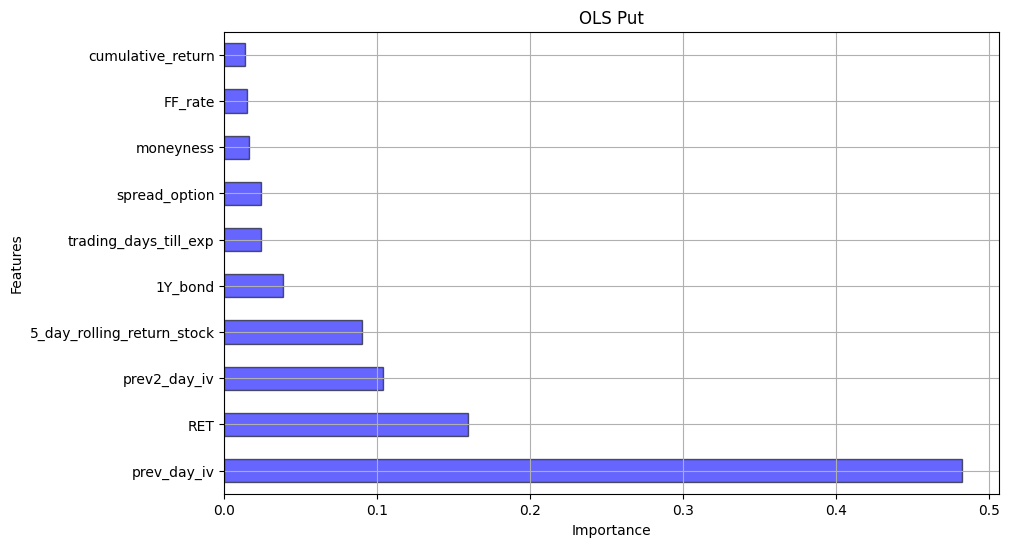

Put Out-of-sample RMSE: 0.15080690037054034
Put Out-of-sample R²: 0.6264067215458075
Call In-sample RMSE: 0.19038668158591157
Call In-sample R²: 0.7311493343833906


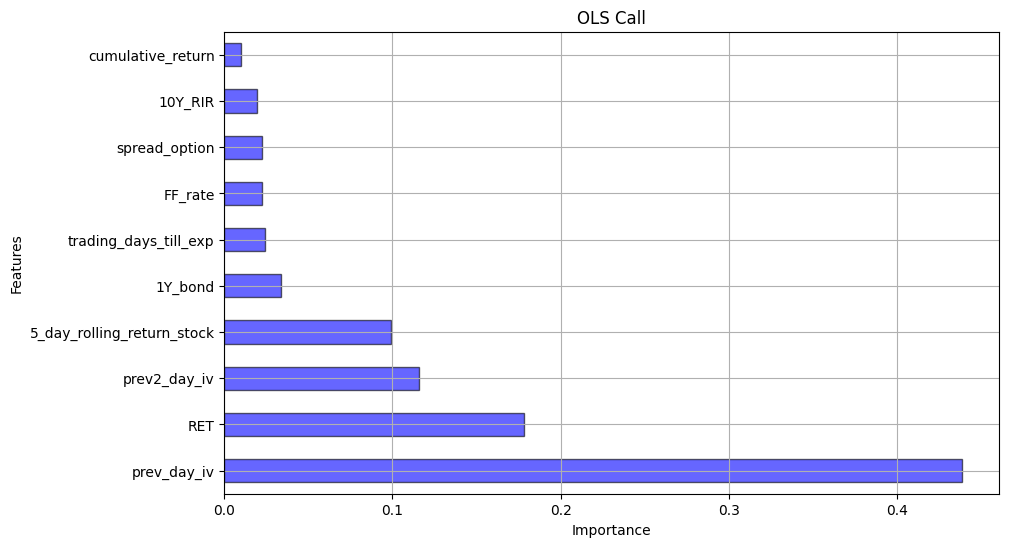

Call Out-of-sample RMSE: 0.15088987389537922
Call Out-of-sample R²: 0.5999395265511848
Squared error differences and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_ols.csv


In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to run OLS regression and calculate performance metrics
def run_ols(data, title):
    """Runs OLS regression, calculates RMSE and R², and returns the top 10 most important features, normalized."""
    # Prepare the data
    y = data['impl_volatility']
    X = data.drop(columns=['date', 'Ticker', 'cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Predict on the in-sample data
    y_pred = model.predict(X)

    # Calculate RMSE for in-sample data
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{title} In-sample RMSE: {rmse}')

    # Calculate R² for in-sample data
    r2 = r2_score(y, y_pred)
    print(f'{title} In-sample R²: {r2}')

    # Create the feature importance plot (sum of importances = 1)
    coefs = model.params.drop('const')  # Drop constant term
    importance = coefs.abs() / coefs.abs().sum()  # Normalize importance so it sums to 1

    # Get top 10 most important features
    top_10_features = importance.sort_values(ascending=False).head(10)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    ax = top_10_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black', linewidth=1)
    plt.grid(True)
    ax.set_title(f'OLS {title}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')

    plt.show()

    return model, top_10_features  # No need to return RMSE/R² for in-sample

# Function to evaluate the model on test data and return prediction errors
def evaluate_on_test_set(model, test_data, title):
    """Evaluate the model on test data, return the list of prediction errors."""
    # Prepare the test data using only the features from the in-sample model
    selected_features = model.params.index.drop('const')  # Use the same features selected in the training model
    X_test = test_data[selected_features]
    X_test = sm.add_constant(X_test)

    # Predict on the test set
    y_test = test_data['impl_volatility']
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{title} Out-of-sample RMSE: {rmse}')

    # Calculate R²
    r2 = r2_score(y_test, y_pred)
    print(f'{title} Out-of-sample R²: {r2}')

    # Return the list of prediction errors
    prediction_errors = y_test - y_pred
    return prediction_errors

# Run OLS for puts data
puts_model, puts_top_11_features = run_ols(puts_data_all, "Put")
puts_test_errors = evaluate_on_test_set(puts_model, puts_data_test, "Put")

# Run OLS for calls data
calls_model, calls_top_11_features = run_ols(calls_data_all, "Call")
calls_test_errors = evaluate_on_test_set(calls_model, calls_data_test, "Call")

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Function to calculate Newey-West standard error for a series of errors
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    # Create a simple OLS model for the errors, assuming they have a mean of zero
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    
    # Extract the standard error of the constant term (Newey-West standard error)
    nw_std_error = ols_model.bse[0]
    return nw_std_error

# Find the maximum length between the two error lists
max_length = max(len(puts_test_errors), len(calls_test_errors))

# Pad the shorter list with 0s to match the length of the longer list
puts_test_errors_padded = np.pad(puts_test_errors, (0, max_length - len(puts_test_errors)), 'constant', constant_values=0)
calls_test_errors_padded = np.pad(calls_test_errors, (0, max_length - len(calls_test_errors)), 'constant', constant_values=0)

# Calculate the Newey-West standard error for each model
lag_value = 1  # You can adjust this lag depending on the autocorrelation you expect in your data
puts_nw_std_error = newey_west_standard_error(puts_test_errors_padded, lag=lag_value)
calls_nw_std_error = newey_west_standard_error(calls_test_errors_padded, lag=lag_value)

# Save the padded errors, squared differences, and Newey-West statistics to a DataFrame
dm_test_data = pd.DataFrame({
    'Put Errors': puts_test_errors_padded,
    'Call Errors': calls_test_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Fill with the same value for each row
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Fill with the same value for each row
})

# Specify the exact path where the file should be saved
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_ols.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"Squared error differences and Newey-West statistics saved to {file_path}")



# OLS -> LSTM Comparison

In [50]:
puts_data_all = total_train[total_train['cp_flag'] == 'P']
puts_data_test = test_data[test_data['cp_flag'] == 'P']
calls_data_all = total_train[total_train['cp_flag'] == 'C']
calls_data_test = test_data[test_data['cp_flag'] == 'C']


def process_option_data(data, cp_flag_value):
  """
  Process the option data to calculate the mean, count of rows averaged, and the standard deviation 
  of all columns except 'implied_volatility' for each date, and filter by the cp_flag ('C' or 'P').

  Parameters:
  data (pd.DataFrame): The input data containing option data.
  cp_flag_value (str): The value of cp_flag to filter by ('C' for Call, 'P' for Put).

  Returns:
  pd.DataFrame: A processed DataFrame with the mean, count of rows, and standard deviation of all columns except 'implied_volatility'.
  """
  # Drop the column 'Ticker'
  data = data.drop(columns=['Ticker', 'cp_flag'])

  print(data)
  # Step 2: Group by 'date' and calculate the mean for all columns except 'implied_volatility'
  grouped_mean = data.groupby('date').mean()

  # Step 6: Reset the index to make 'date' a column again
  grouped_mean = grouped_mean.reset_index()
  
  # Step 7: Add the cp_flag to the resulting DataFrame
  grouped_mean['cp_flag'] = cp_flag_value
  
  return grouped_mean

# Example usage
puts_data_test = process_option_data(puts_data_test, 'P')
puts_data_all = process_option_data(puts_data_all, 'P')
calls_data_test = process_option_data(calls_data_test, 'C')
calls_data_all = process_option_data(calls_data_all, 'C')



#   # Prepare the train and test data
# X_train_p = data_p.drop(columns=['impl_volatility', 'date', 'cp_flag'])  # Training features
# y_train_p = data_p['impl_volatility']  # Training target

# X_test_p = data_p_t.drop(columns=['impl_volatility', 'date', 'cp_flag'])  # Test features
# y_test_p = data_p_t['impl_volatility']  # Test target

            date  trading_days_till_exp  moneyness  impl_volatility  \
36352 2021-01-04                      4     -1.977         0.622737   
36353 2021-01-04                      4     -1.835         0.598160   
36354 2021-01-04                      4     -1.694         0.570362   
36355 2021-01-04                      4     -1.554         0.549241   
36356 2021-01-04                      4     -1.415         0.526871   
...          ...                    ...        ...              ...   
71690 2021-12-30                      1     -0.027         0.484270   
71691 2021-12-30                      1      0.081         0.503165   
71692 2021-12-30                      1      0.190         0.536047   
71693 2021-12-30                      1      0.298         0.550971   
71694 2021-12-30                      1      0.405         0.574417   

       prev_day_iv  prev2_day_iv  volume_option  spread_option       BIDLO  \
36352     0.404451      0.452074           1499           0.01   133.

In [54]:
puts_data_all


,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,volume_option,spread_option,BIDLO,ASKHI,...,gold_price,reces_indi,10Y_RIR,1Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix,cp_flag
0,2019-01-02,2.0,-0.768588,0.591828,0.585434,0.000000,1222.520270,0.292230,772.484054,807.074579,...,449.000000,0.130000,2.66,2.5342,31.72,31.74,28.57,28.57,3.17,P
1,2019-01-03,1.0,-0.966648,0.559444,0.598462,0.576153,2146.390625,0.407969,812.479532,832.003520,...,449.354839,0.131290,2.66,2.5342,31.46,31.46,22.82,22.82,8.64,P
2,2019-01-04,5.0,-0.695649,0.500506,0.562212,0.579644,448.024390,0.152634,718.971776,763.310093,...,449.709677,0.132581,2.56,2.4762,25.82,28.95,24.47,26.59,4.48,P
3,2019-01-07,4.0,-0.740630,0.553899,0.507827,0.563777,890.621005,0.161826,795.880006,818.888789,...,450.064516,0.133871,2.67,2.5189,24.04,24.38,20.84,20.85,3.54,P
4,2019-01-08,3.0,-0.749615,0.516898,0.553032,0.506757,1388.743017,0.153631,801.499080,841.119991,...,451.129032,0.137742,2.70,2.5534,23.42,23.42,21.11,21.47,2.31,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2020-12-24,4.0,-0.661396,0.290516,0.298394,0.289907,2056.485149,0.208812,1528.462825,1555.365289,...,662.516129,3.088065,0.96,0.1098,19.91,19.91,17.63,19.20,2.28,P
499,2020-12-28,3.0,-0.605580,0.394037,0.279240,0.285380,4729.910714,0.135000,1607.792577,1625.966912,...,663.703226,3.081613,0.94,0.1085,19.18,19.18,16.85,17.12,2.33,P
500,2020-12-29,2.0,-0.736495,0.357299,0.409906,0.282478,5544.968421,0.145368,1678.555264,1699.476530,...,668.451613,3.055806,0.94,0.1146,17.16,20.42,17.16,20.05,3.26,P
501,2020-12-30,1.0,-0.728838,0.362238,0.358868,0.410953,6584.925000,0.271250,1628.244685,1692.656003,...,669.638710,3.049355,0.94,0.1171,20.04,22.68,19.76,21.47,2.92,P


Put In-sample RMSE: 0.10145841960186307
Put In-sample R²: 0.8241351761836756


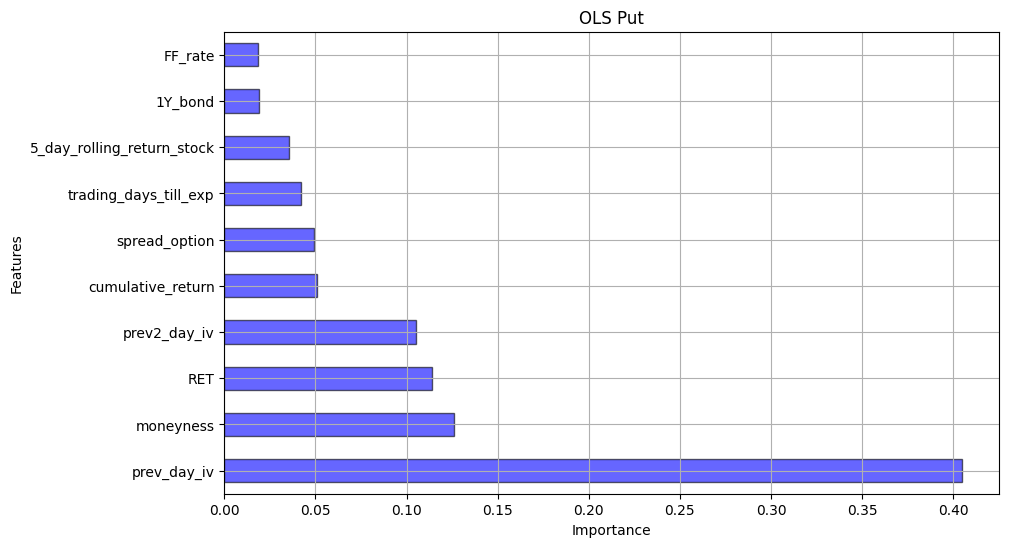

Put Out-of-sample RMSE: 0.11430955740801442
Put Out-of-sample R²: 0.06666416274757248
Call In-sample RMSE: 0.10249532922265028
Call In-sample R²: 0.7943334224335518


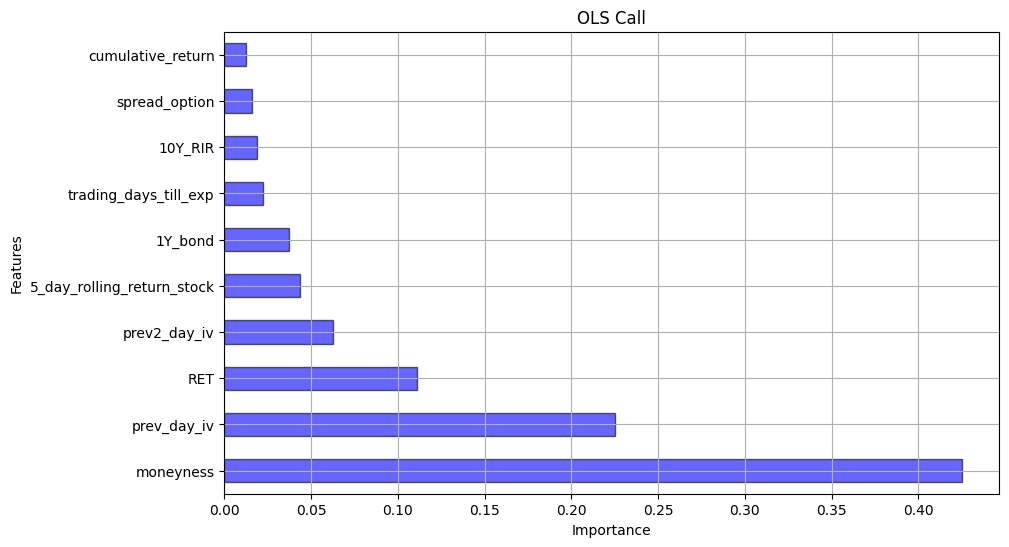

Call Out-of-sample RMSE: 0.11309468058949972
Call Out-of-sample R²: 0.3026645379504719
Squared error differences and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_ols_lstm.csv


In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to run OLS regression and calculate performance metrics
def run_ols(data, title):
    """Runs OLS regression, calculates RMSE and R², and returns the top 10 most important features, normalized."""
    # Prepare the data
    y = data['impl_volatility']
    X = data.drop(columns=['date','cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Predict on the in-sample data
    y_pred = model.predict(X)

    # Calculate RMSE for in-sample data
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{title} In-sample RMSE: {rmse}')

    # Calculate R² for in-sample data
    r2 = r2_score(y, y_pred)
    print(f'{title} In-sample R²: {r2}')

    # Create the feature importance plot (sum of importances = 1)
    coefs = model.params.drop('const')  # Drop constant term
    importance = coefs.abs() / coefs.abs().sum()  # Normalize importance so it sums to 1

    # Get top 10 most important features
    top_10_features = importance.sort_values(ascending=False).head(10)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    ax = top_10_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black', linewidth=1)
    plt.grid(True)
    ax.set_title(f'OLS {title}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')

    plt.show()

    return model, top_10_features  # No need to return RMSE/R² for in-sample

# Function to evaluate the model on test data and return prediction errors
def evaluate_on_test_set(model, test_data, title):
    """Evaluate the model on test data, return the list of prediction errors."""
    # Prepare the test data using only the features from the in-sample model
    selected_features = model.params.index.drop('const')  # Use the same features selected in the training model
    X_test = test_data[selected_features]
    X_test = sm.add_constant(X_test)

    # Predict on the test set
    y_test = test_data['impl_volatility']
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{title} Out-of-sample RMSE: {rmse}')

    # Calculate R²
    r2 = r2_score(y_test, y_pred)
    print(f'{title} Out-of-sample R²: {r2}')

    # Return the list of prediction errors
    prediction_errors = y_test - y_pred
    return prediction_errors

# Run OLS for puts data
puts_model, puts_top_11_features = run_ols(puts_data_all, "Put")
puts_test_errors = evaluate_on_test_set(puts_model, puts_data_test, "Put")

# Run OLS for calls data
calls_model, calls_top_11_features = run_ols(calls_data_all, "Call")
calls_test_errors = evaluate_on_test_set(calls_model, calls_data_test, "Call")

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Function to calculate Newey-West standard error for a series of errors
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    # Create a simple OLS model for the errors, assuming they have a mean of zero
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    
    # Extract the standard error of the constant term (Newey-West standard error)
    nw_std_error = ols_model.bse[0]
    return nw_std_error

# Find the maximum length between the two error lists
max_length = max(len(puts_test_errors), len(calls_test_errors))

# Pad the shorter list with 0s to match the length of the longer list
puts_test_errors_padded = np.pad(puts_test_errors, (0, max_length - len(puts_test_errors)), 'constant', constant_values=0)
calls_test_errors_padded = np.pad(calls_test_errors, (0, max_length - len(calls_test_errors)), 'constant', constant_values=0)

# Calculate the Newey-West standard error for each model
lag_value = 1  # You can adjust this lag depending on the autocorrelation you expect in your data
puts_nw_std_error = newey_west_standard_error(puts_test_errors_padded, lag=lag_value)
calls_nw_std_error = newey_west_standard_error(calls_test_errors_padded, lag=lag_value)

# Save the padded errors, squared differences, and Newey-West statistics to a DataFrame
dm_test_data = pd.DataFrame({
    'Put Errors': puts_test_errors_padded,
    'Call Errors': calls_test_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Fill with the same value for each row
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Fill with the same value for each row
})

# Specify the exact path where the file should be saved
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_ols_lstm.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"Squared error differences and Newey-West statistics saved to {file_path}")



Puts (cp_flag = 'P') Model Summary:
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     9466.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:43   Log-Likelihood:                 18295.
No. Observations:               72964   AIC:                        -3.654e+04
Df Residuals:                   72937   BIC:                        -3.629e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

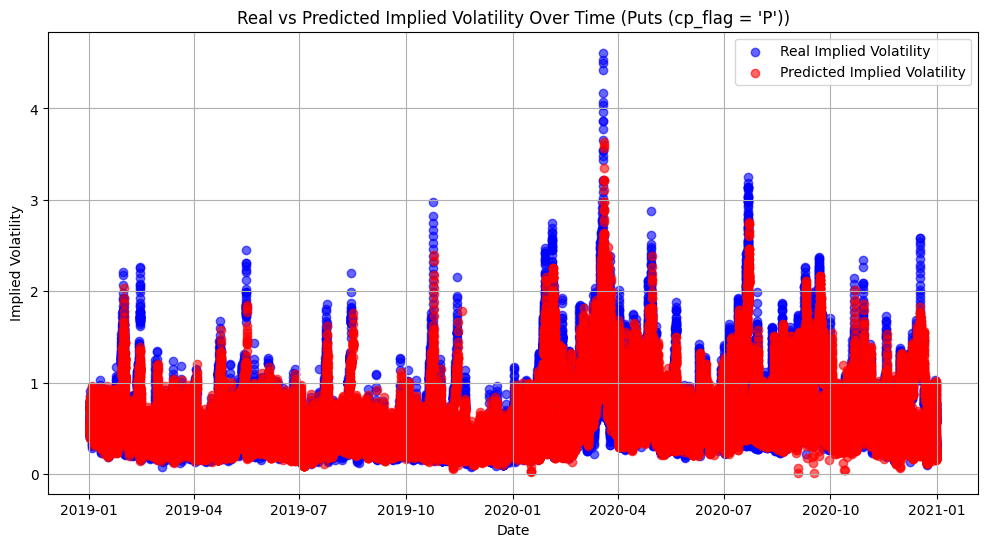

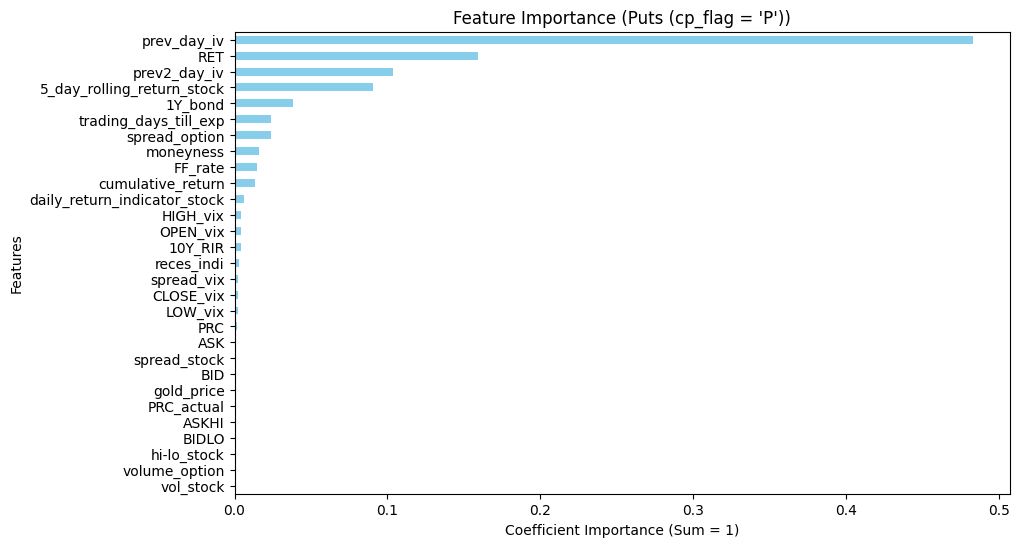

Puts (cp_flag = 'P') Out-of-sample RMSE: 0.15080690037054034
Puts (cp_flag = 'P') Out-of-sample R²: 0.6264067215458075


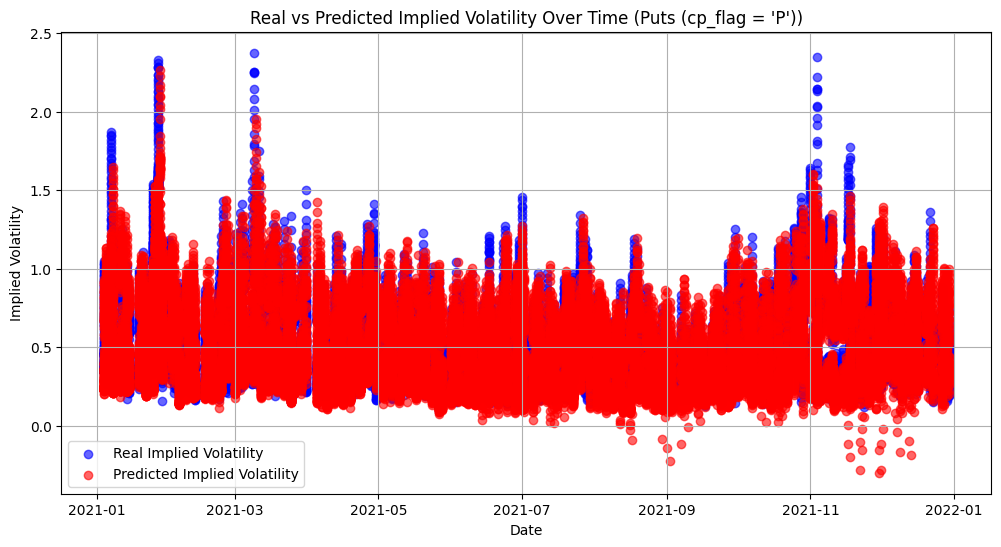

Calls (cp_flag = 'C') Model Summary:
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     7564.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:44   Log-Likelihood:                 17346.
No. Observations:               72347   AIC:                        -3.464e+04
Df Residuals:                   72320   BIC:                        -3.439e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

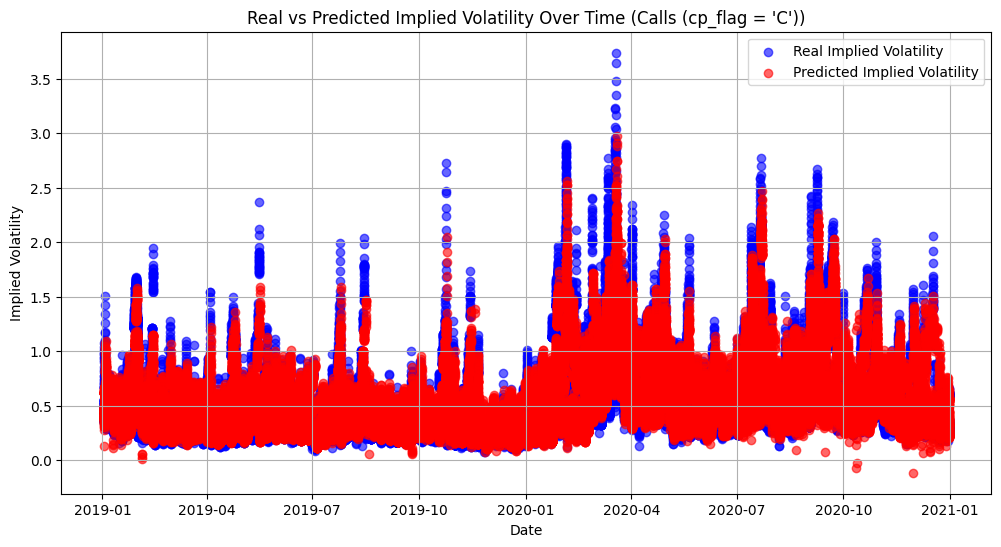

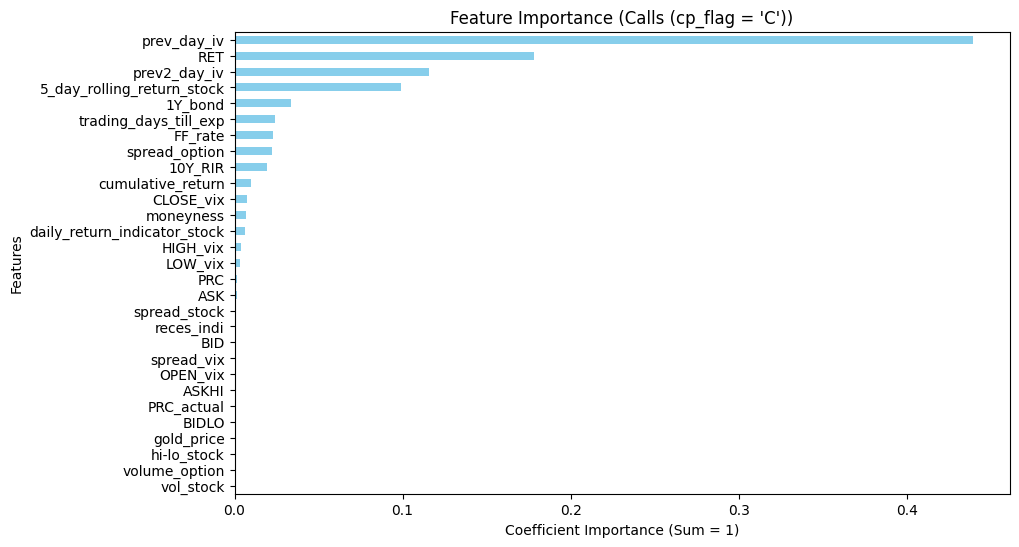

Calls (cp_flag = 'C') Out-of-sample RMSE: 0.15088987389537922
Calls (cp_flag = 'C') Out-of-sample R²: 0.5999395265511848


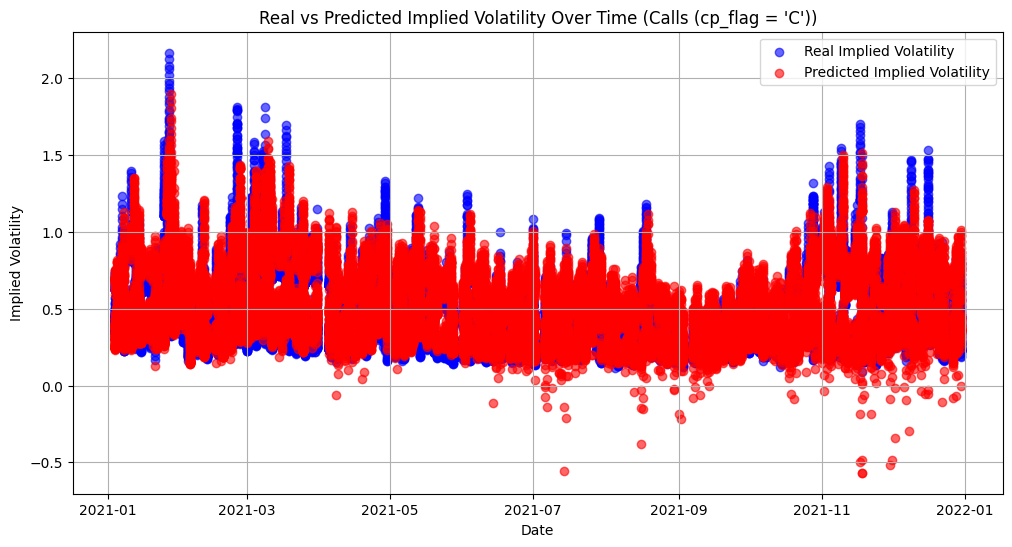

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def run_ols(data, title):
    """Runs OLS regression, calculates RMSE and R², and plots results."""
    # Prepare the data
    y = data['impl_volatility']
    X = data.drop(columns=['date', 'Ticker', 'cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    print(f"{title} Model Summary:")
    print(model.summary())

    # Predict on the in-sample data
    y_pred = model.predict(X)

    # Calculate RMSE for in-sample data
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{title} In-sample RMSE: {rmse}')

    # Calculate R² for in-sample data
    r2 = r2_score(y, y_pred)
    print(f'{title} In-sample R²: {r2}')

    # # Plot y against y_pred
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y, y_pred, alpha=0.5)
    # plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    # plt.xlabel('Actual Implied Volatility')
    # plt.ylabel('Predicted Implied Volatility')
    # plt.title(f'Actual vs Predicted Implied Volatility ({title})')
    # plt.show()

    # Plot Real vs Predicted Implied Volatility over time
    plt.figure(figsize=(12, 6))
    plt.scatter(data['date'], y, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(data['date'], y_pred, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create the feature importance plot (sum of importances = 1)
    coefs = model.params.drop('const')  # Drop constant term
    importance = coefs.abs() / coefs.abs().sum()  # Scale importance so it sums to 1
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    importance.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Feature Importance ({title})')
    plt.xlabel('Coefficient Importance (Sum = 1)')
    plt.ylabel('Features')
    plt.show()


    return model

def evaluate_on_test_set(model, test_data, title):
    """Evaluate the model on test data, calculate RMSE and R², and plot results."""
    # Prepare the test data using only the features from the in-sample model
    selected_features = model.params.index.drop('const')  # Use the same features selected in the training model
    X_test = test_data[selected_features]
    X_test = sm.add_constant(X_test)

    # Predict on the test set
    y_test = test_data['impl_volatility']
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{title} Out-of-sample RMSE: {rmse}')

    # Calculate R²
    r2 = r2_score(y_test, y_pred)
    print(f'{title} Out-of-sample R²: {r2}')

    # # Plot y_test against y_pred
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_test, y_pred, alpha=0.5)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    # plt.xlabel('Actual Implied Volatility')
    # plt.ylabel('Predicted Implied Volatility')
    # plt.title(f'Actual vs Predicted Implied Volatility ({title})')
    # plt.show()

    # Plot Real vs Predicted Implied Volatility over time
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], y_test, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], y_pred, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run OLS for puts data
ols_puts = run_ols(puts_data_all, "Puts (cp_flag = 'P')")

# Evaluate the puts model on the test set
evaluate_on_test_set(ols_puts, puts_data_test, "Puts (cp_flag = 'P')")

# Run OLS for calls data
ols_calls = run_ols(calls_data_all, "Calls (cp_flag = 'C')")

# Evaluate the calls model on the test set
evaluate_on_test_set(ols_calls, calls_data_test, "Calls (cp_flag = 'C')")


# Now for the ADHOC BS

# Scaled

In [30]:
# Select the relevant columns for ADHBS model
calls_data_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_c.parquet') 
calls_data_test = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_c_total.parquet')
puts_data_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_p.parquet')
puts_data_test = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_p_total.parquet')

selected_columns = ['Ticker', 'date', 'cp_flag', 'impl_volatility', 'prev_day_iv','moneyness', 'trading_days_till_exp', 'moneyness_squared', 'tau_squared', 'moneyness_tau']

train_calls_data = calls_data_all[selected_columns]
test_calls_data = calls_data_test[selected_columns]
train_puts_data = puts_data_all[selected_columns]
test_puts_data = puts_data_test[selected_columns]

test_puts_data

,Ticker,date,cp_flag,impl_volatility,prev_day_iv,moneyness,trading_days_till_exp,moneyness_squared,tau_squared,moneyness_tau
36352,AAPL,2021-01-04,P,0.622737,-0.485955,-1.763565,0.597483,2.505290,0.500101,-2.103130
36353,AAPL,2021-01-04,P,0.598160,-0.540789,-1.563909,0.597483,2.034477,0.500101,-1.886121
36354,AAPL,2021-01-04,P,0.570362,-0.566378,-1.365659,0.597483,1.601686,0.500101,-1.670640
36355,AAPL,2021-01-04,P,0.549241,-0.590342,-1.168815,0.597483,1.206182,0.500101,-1.456687
36356,AAPL,2021-01-04,P,0.526871,-0.633938,-0.973377,0.597483,0.847233,0.500101,-1.244263
...,...,...,...,...,...,...,...,...,...,...
71690,TSLA,2021-12-30,P,0.484270,-0.177116,0.978189,-1.592475,-0.893620,-1.362515,0.901682
71691,TSLA,2021-12-30,P,0.503165,-0.176629,1.130040,-1.592475,-0.888548,-1.362515,0.967702
71692,TSLA,2021-12-30,P,0.536047,-0.163246,1.283297,-1.592475,-0.862855,-1.362515,1.034333
71693,TSLA,2021-12-30,P,0.550971,-0.150542,1.435148,-1.592475,-0.817015,-1.362515,1.100352


# Nonscaled

In [31]:
# selected_columns = ['Ticker', 'date', 'cp_flag', 'impl_volatility', 'moneyness', 'trading_days_till_exp', 'moneyness_squared', 'tau_squared', 'moneyness_tau']

# data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_nonscaled.parquet')
# datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_nonscaled.parquet')

# test_data = datat[datat['date'] >= '2021-01-01']
# total_train = data[data['date'] < '2021-01-01']

# puts_data_all = total_train[total_train['cp_flag'] == 'P']
# puts_data_test = test_data[test_data['cp_flag'] == 'P']
# calls_data_all = total_train[total_train['cp_flag'] == 'C']
# calls_data_test = test_data[test_data['cp_flag'] == 'C']

# train_calls_data = calls_data_all[selected_columns]
# test_calls_data = calls_data_test[selected_columns]
# train_puts_data = puts_data_all[selected_columns]
# test_puts_data = puts_data_test[selected_columns]

# test_puts_data

AHBS Model Summary for Puts (cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     689.5
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:46   Log-Likelihood:                -33860.
No. Observations:               72964   AIC:                         6.773e+04
Df Residuals:                   72958   BIC:                         6.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/2542386628.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))


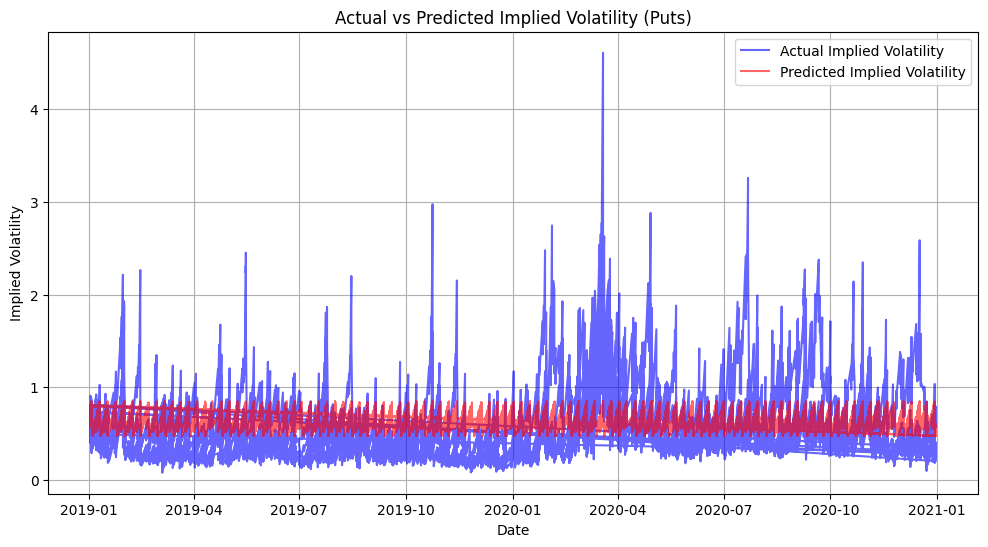

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate predictions using the model
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Plot actual vs predicted implied volatility
plt.figure(figsize=(12, 6))
plt.plot(train_puts_data['date'], train_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.plot(train_puts_data['date'], train_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts)')
plt.legend()
plt.grid(True)
plt.show()


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     689.5
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:46   Log-Likelihood:                -33860.
No. Observations:               72964   AIC:                         6.773e+04
Df Residuals:                   72958   BIC:                         6.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1135662867.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1135662867.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_puts_data['predicted_impl_volatility'] = adhbs_mod

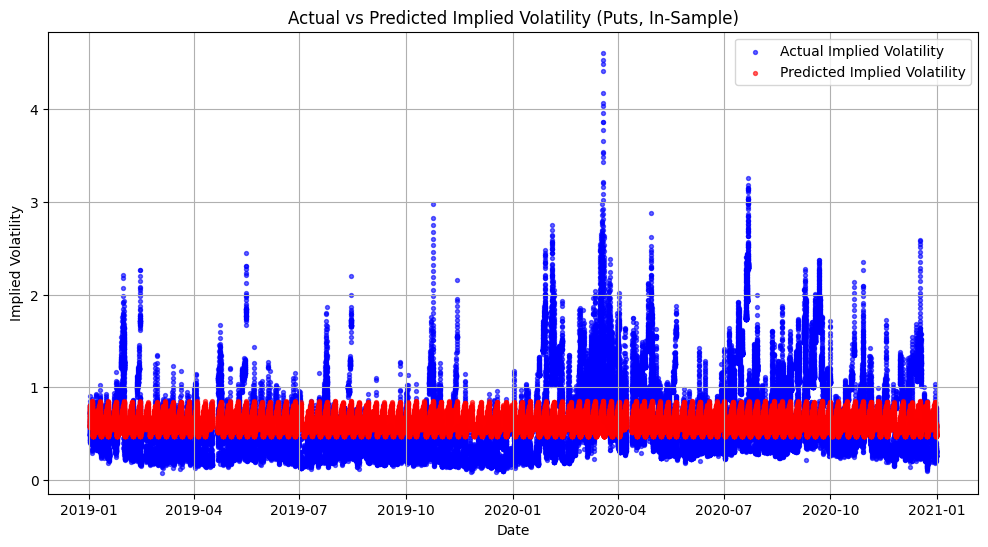

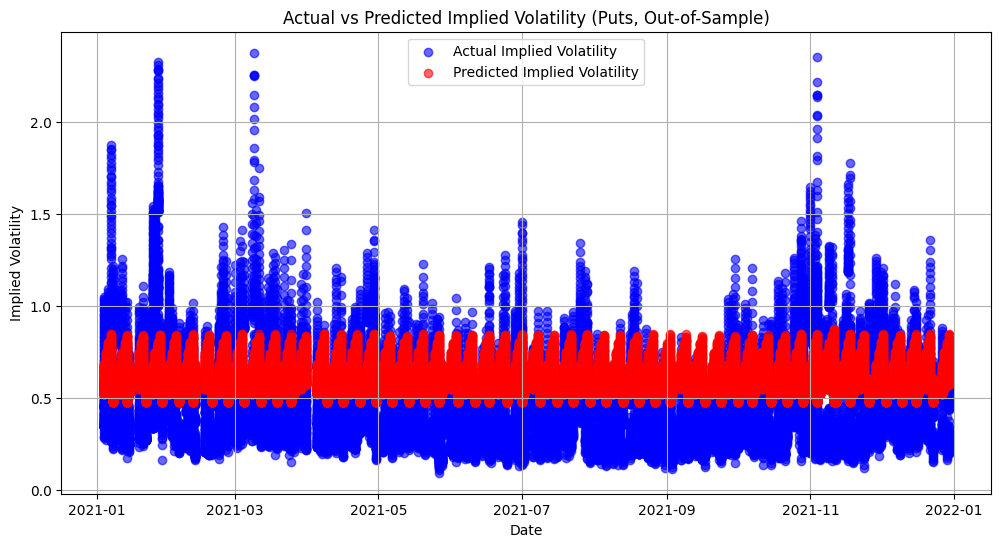

AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     504.6
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:48   Log-Likelihood:                -28932.
No. Observations:               72347   AIC:                         5.788e+04
Df Residuals:                   72341   BIC:                         5.793e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1135662867.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1135662867.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_calls_data['predicted_impl_volatility'] = adhbs

In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for puts
r2_puts = r2_score(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility'])
rmse_puts = np.sqrt(mean_squared_error(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Puts: {r2_puts}")
print(f"Out-of-Sample RMSE for Puts: {rmse_puts}")

# Plot actual vs predicted implied volatility for puts (In-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(train_puts_data['date'], train_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6, s=8)
plt.scatter(train_puts_data['date'], train_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6, s=8)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, In-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted implied volatility for puts (Out-of-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(test_puts_data['date'], test_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.scatter(test_puts_data['date'], test_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Fit the AHBS model for calls (In-Sample)
adhbs_model_calls = adhbs_model(train_calls_data)
print("AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Generate in-sample predictions for calls
train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for calls
test_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(test_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for calls
r2_calls = r2_score(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility'])
rmse_calls = np.sqrt(mean_squared_error(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Calls: {r2_calls}")
print(f"Out-of-Sample RMSE for Calls: {rmse_calls}")

# # Plot actual vs predicted implied volatility for calls (In-Sample)
# plt.figure(figsize=(12, 6))
# plt.scatter(train_calls_data['date'], train_calls_data['impl_volatility'], label='Actual Implied Volatility (In-Sample)', color='blue', alpha=0.6)
# plt.scatter(train_calls_data['date'], train_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (In-Sample)', color='red', alpha=0.6)
# plt.xlabel('Date')
# plt.ylabel('Implied Volatility')
# plt.title('Actual vs Predicted Implied Volatility (Calls, In-Sample)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot actual vs predicted implied volatility for calls (Out-of-Sample)
# plt.figure(figsize=(12, 6))
# plt.scatter(test_calls_data['date'], test_calls_data['impl_volatility'], label='Actual Implied Volatility (Out-of-Sample)', color='blue', alpha=0.6)
# plt.scatter(test_calls_data['date'], test_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (Out-of-Sample)', color='red', alpha=0.6)
# plt.xlabel('Date')
# plt.ylabel('Implied Volatility')
# plt.title('Actual vs Predicted Implied Volatility (Calls, Out-of-Sample)')
# plt.legend()
# plt.grid(True)
# plt.show()


In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    # Create a simple OLS model for the errors
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    
    # Extract the standard error of the constant term (Newey-West standard error)
    nw_std_error = ols_model.bse[0]
    return nw_std_error

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Newey-West standard error for puts
puts_errors = test_puts_data['impl_volatility'] - test_puts_data['predicted_impl_volatility']
puts_nw_std_error = newey_west_standard_error(puts_errors, lag=1)

print(f"Newey-West Standard Error for Puts: {puts_nw_std_error}")

# Fit the AHBS model for calls (In-Sample)
adhbs_model_calls = adhbs_model(train_calls_data)
print("AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Generate in-sample predictions for calls
train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for calls
test_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(test_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Newey-West standard error for calls
calls_errors = test_calls_data['impl_volatility'] - test_calls_data['predicted_impl_volatility']
calls_nw_std_error = newey_west_standard_error(calls_errors, lag=1)

print(f"Newey-West Standard Error for Calls: {calls_nw_std_error}")

# Pad the shorter error list with zeros to ensure both lists have the same length
max_length = max(len(puts_errors), len(calls_errors))

puts_errors_padded = np.pad(puts_errors, (0, max_length - len(puts_errors)), 'constant', constant_values=0)
calls_errors_padded = np.pad(calls_errors, (0, max_length - len(calls_errors)), 'constant', constant_values=0)

# Save the results to a DataFrame and CSV
dm_test_data = pd.DataFrame({
    'Put Errors': puts_errors_padded,
    'Call Errors': calls_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Constant value for all rows
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Constant value for all rows
})

# Specify the file path for the CSV
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_adhbs.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"AHBS test errors and Newey-West statistics saved to {file_path}")


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     689.5
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:10:10   Log-Likelihood:                -33860.
No. Observations:               72964   AIC:                         6.773e+04
Df Residuals:                   72958   BIC:                         6.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1128744016.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/1128744016.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_puts_data['predicted_impl_volatility'] = adhbs_mod

AHBS test errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_adhbs.csv


# ADHOC BS but now averaged daily


In [45]:
# Select the relevant columns for ADHBS model
calls_data_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_c.parquet') 
calls_data_test = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_c_total.parquet')
puts_data_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_p.parquet')
puts_data_test = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_p_total.parquet')

selected_columns = ['Ticker', 'date', 'cp_flag', 'impl_volatility', 'prev_day_iv','moneyness', 'trading_days_till_exp', 'moneyness_squared', 'tau_squared', 'moneyness_tau']

train_calls_data = calls_data_all[selected_columns]
test_calls_data = calls_data_test[selected_columns]
train_puts_data = puts_data_all[selected_columns]
test_puts_data = puts_data_test[selected_columns]

In [46]:
def process_option_data(data, cp_flag_value):
  """
  Process the option data to calculate the mean, count of rows averaged, and the standard deviation 
  of all columns except 'implied_volatility' for each date, and filter by the cp_flag ('C' or 'P').

  Parameters:
  data (pd.DataFrame): The input data containing option data.
  cp_flag_value (str): The value of cp_flag to filter by ('C' for Call, 'P' for Put).

  Returns:
  pd.DataFrame: A processed DataFrame with the mean, count of rows, and standard deviation of all columns except 'implied_volatility'.
  """
  # Drop the column 'Ticker'
  data = data.drop(columns=['Ticker', 'cp_flag'])

  print(data)
  # Step 2: Group by 'date' and calculate the mean for all columns except 'implied_volatility'
  grouped_mean = data.groupby('date').mean()

  # Step 6: Reset the index to make 'date' a column again
  grouped_mean = grouped_mean.reset_index()
  
  # Step 7: Add the cp_flag to the resulting DataFrame
  grouped_mean['cp_flag'] = cp_flag_value
  
  return grouped_mean

# Example usage
test_puts_data = process_option_data(test_puts_data, 'P')
train_puts_data = process_option_data(train_puts_data, 'P')
test_calls_data = process_option_data(test_calls_data, 'C')
train_calls_data = process_option_data(train_calls_data, 'C')



#   # Prepare the train and test data
# X_train_p = data_p.drop(columns=['impl_volatility', 'date', 'cp_flag'])  # Training features
# y_train_p = data_p['impl_volatility']  # Training target

# X_test_p = data_p_t.drop(columns=['impl_volatility', 'date', 'cp_flag'])  # Test features
# y_test_p = data_p_t['impl_volatility']  # Test target

            date  impl_volatility  prev_day_iv  moneyness  \
36352 2021-01-04         0.622737    -0.485955  -1.763565   
36353 2021-01-04         0.598160    -0.540789  -1.563909   
36354 2021-01-04         0.570362    -0.566378  -1.365659   
36355 2021-01-04         0.549241    -0.590342  -1.168815   
36356 2021-01-04         0.526871    -0.633938  -0.973377   
...          ...              ...          ...        ...   
71690 2021-12-30         0.484270    -0.177116   0.978189   
71691 2021-12-30         0.503165    -0.176629   1.130040   
71692 2021-12-30         0.536047    -0.163246   1.283297   
71693 2021-12-30         0.550971    -0.150542   1.435148   
71694 2021-12-30         0.574417    -0.131431   1.585593   

       trading_days_till_exp  moneyness_squared  tau_squared  moneyness_tau  
36352               0.597483           2.505290     0.500101      -2.103130  
36353               0.597483           2.034477     0.500101      -1.886121  
36354               0.597483     

In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    # Create a simple OLS model for the errors
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    
    # Extract the standard error of the constant term (Newey-West standard error)
    nw_std_error = ols_model.bse[0]
    return nw_std_error

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Newey-West standard error for puts
puts_errors = test_puts_data['impl_volatility'] - test_puts_data['predicted_impl_volatility']
puts_nw_std_error = newey_west_standard_error(puts_errors, lag=1)

print(f"Newey-West Standard Error for Puts: {puts_nw_std_error}")

# Fit the AHBS model for calls (In-Sample)
adhbs_model_calls = adhbs_model(train_calls_data)
print("AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Generate in-sample predictions for calls
train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for calls
test_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(test_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Newey-West standard error for calls
calls_errors = test_calls_data['impl_volatility'] - test_calls_data['predicted_impl_volatility']
calls_nw_std_error = newey_west_standard_error(calls_errors, lag=1)

print(f"Newey-West Standard Error for Calls: {calls_nw_std_error}")

# Pad the shorter error list with zeros to ensure both lists have the same length
max_length = max(len(puts_errors), len(calls_errors))

puts_errors_padded = np.pad(puts_errors, (0, max_length - len(puts_errors)), 'constant', constant_values=0)
calls_errors_padded = np.pad(calls_errors, (0, max_length - len(calls_errors)), 'constant', constant_values=0)

# Save the results to a DataFrame and CSV
dm_test_data = pd.DataFrame({
    'Put Errors': puts_errors_padded,
    'Call Errors': calls_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Constant value for all rows
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Constant value for all rows
})

# Specify the file path for the CSV
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_adhbs_lstm.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"AHBS test errors and Newey-West statistics saved to {file_path}")


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     26.40
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.11e-23
Time:                        13:39:20   Log-Likelihood:                 59.312
No. Observations:                 503   AIC:                            -106.6
Df Residuals:                     497   BIC:                            -81.30
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/17641209.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43840/17641209.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     26.40
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.11e-23
Time:                        13:39:53   Log-Likelihood:                 59.312
No. Observations:                 503   AIC:                            -106.6
Df Residuals:                     497   BIC:                            -81.30
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

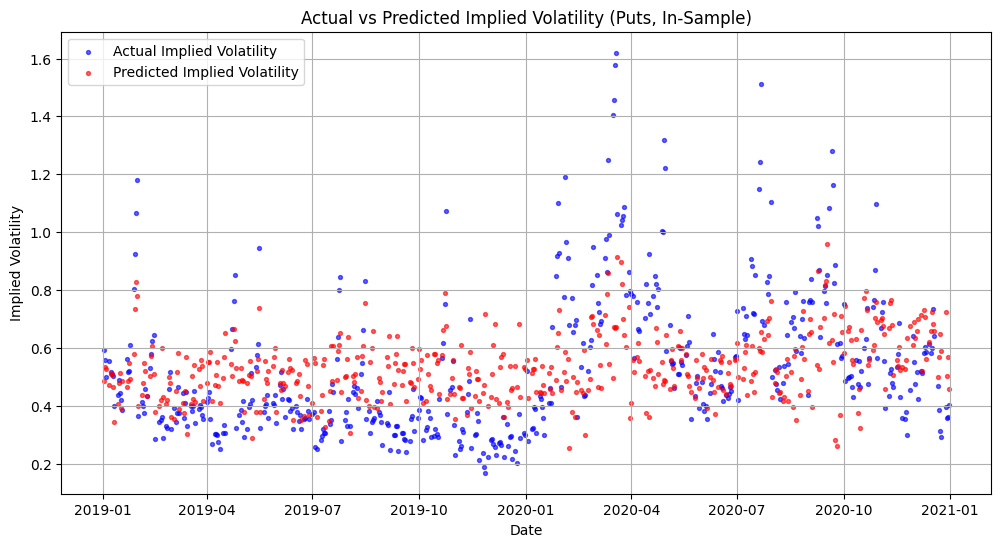

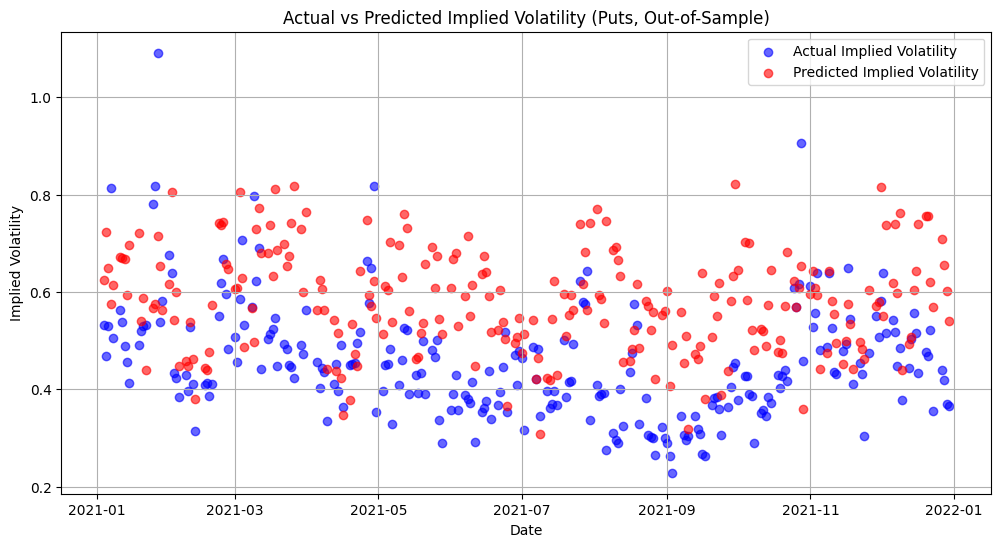

AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     20.34
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.73e-18
Time:                        13:39:53   Log-Likelihood:                 81.152
No. Observations:                 503   AIC:                            -150.3
Df Residuals:                     497   BIC:                            -125.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [48]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for puts
r2_puts = r2_score(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility'])
rmse_puts = np.sqrt(mean_squared_error(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Puts: {r2_puts}")
print(f"Out-of-Sample RMSE for Puts: {rmse_puts}")

# Plot actual vs predicted implied volatility for puts (In-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(train_puts_data['date'], train_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6, s=8)
plt.scatter(train_puts_data['date'], train_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6, s=8)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, In-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted implied volatility for puts (Out-of-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(test_puts_data['date'], test_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.scatter(test_puts_data['date'], test_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Fit the AHBS model for calls (In-Sample)
adhbs_model_calls = adhbs_model(train_calls_data)
print("AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Generate in-sample predictions for calls
train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for calls
test_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(test_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for calls
r2_calls = r2_score(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility'])
rmse_calls = np.sqrt(mean_squared_error(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Calls: {r2_calls}")
print(f"Out-of-Sample RMSE for Calls: {rmse_calls}")

# # Plot actual vs predicted implied volatility for calls (In-Sample)
# plt.figure(figsize=(12, 6))
# plt.scatter(train_calls_data['date'], train_calls_data['impl_volatility'], label='Actual Implied Volatility (In-Sample)', color='blue', alpha=0.6)
# plt.scatter(train_calls_data['date'], train_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (In-Sample)', color='red', alpha=0.6)
# plt.xlabel('Date')
# plt.ylabel('Implied Volatility')
# plt.title('Actual vs Predicted Implied Volatility (Calls, In-Sample)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot actual vs predicted implied volatility for calls (Out-of-Sample)
# plt.figure(figsize=(12, 6))
# plt.scatter(test_calls_data['date'], test_calls_data['impl_volatility'], label='Actual Implied Volatility (Out-of-Sample)', color='blue', alpha=0.6)
# plt.scatter(test_calls_data['date'], test_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (Out-of-Sample)', color='red', alpha=0.6)
# plt.xlabel('Date')
# plt.ylabel('Implied Volatility')
# plt.title('Actual vs Predicted Implied Volatility (Calls, Out-of-Sample)')
# plt.legend()
# plt.grid(True)
# plt.show()
